# Assignment 4

## Overview
In this assignment, the focus is on using the RT-IoT2022 cybersecurity dataset to explore applied machine learning techniques for intrusion detection in IoT systems. The dataset, introduced by Sharmila et al. (2023), captures adversarial and normal network behaviors using over 80 variables derived from IoT devices such as Amazon Alexa and Raspberry Pi, as well as simulated attacks like DDoS and ARP poisoning. These features include metrics like packet counts, flow durations, payload sizes, and TCP/IP-specific flags.

The previous papers highlights the datasets sources, current research, importance of this kind of work, basic regression techniques and further information about the features and transformations.

## Initial Data Reading, Imports and Processing
We will begin by importing some libraries that we will use throughout the analysis and then subsequently import the dataset and show a short preview of what the head of the dataset looks like.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder

file_path = '/Users/tejaleburu/Desktop/RT_IOT2022.csv'
data = pd.read_csv(file_path)
data.drop(columns=['id.orig_p', 'id.resp_p', 'Unnamed: 0'], inplace=True, errors='ignore')
data.dropna(inplace=True)
data.head()

,proto,service,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,Attack_type
0,tcp,mqtt,32.011598,9,5,3,3,0.281148,0.156193,0.437341,...,0.0,2.972918e+07,2.972918e+07,2.972918e+07,2.972918e+07,0.0,64240,26847,502,MQTT_Publish
1,tcp,mqtt,31.883584,9,5,3,3,0.282277,0.156821,0.439097,...,0.0,2.985528e+07,2.985528e+07,2.985528e+07,2.985528e+07,0.0,64240,26847,502,MQTT_Publish
2,tcp,mqtt,32.124053,9,5,3,3,0.280164,0.155647,0.435811,...,0.0,2.984215e+07,2.984215e+07,2.984215e+07,2.984215e+07,0.0,64240,26847,502,MQTT_Publish
3,tcp,mqtt,31.961063,9,5,3,3,0.281593,0.156440,0.438033,...,0.0,2.991377e+07,2.991377e+07,2.991377e+07,2.991377e+07,0.0,64240,26847,502,MQTT_Publish
4,tcp,mqtt,31.902362,9,5,3,3,0.282111,0.156728,0.438839,...,0.0,2.981470e+07,2.981470e+07,2.981470e+07,2.981470e+07,0.0,64240,26847,502,MQTT_Publish


## Splitting Training and Test Data

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

X = data.drop(columns=['Attack_type'])
y = data['Attack_type']

X = pd.get_dummies(X, columns=['proto', 'service'], drop_first=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

## Split Explanation

As mentioned before in previous papers, we have seen that there in an inbalance in Y, so if it we did some random sampling -- this would not be effective, as we may end up with none of some categories in the train/test set. Therefore, we implement stratified sampling. We fix the seed to ensure reproducibility, and create a proportional class distribution. 

## Modelling & Feature Selection

Selected Features: Index(['flow_duration', 'fwd_pkts_per_sec', 'flow_pkts_per_sec',
       'fwd_header_size_tot', 'fwd_pkts_payload.min', 'fwd_pkts_payload.max',
       'fwd_pkts_payload.tot', 'fwd_pkts_payload.avg', 'flow_pkts_payload.max',
       'flow_pkts_payload.tot', 'flow_pkts_payload.avg',
       'flow_pkts_payload.std', 'flow_iat.max', 'flow_iat.tot',
       'fwd_subflow_bytes', 'active.max', 'active.tot', 'active.avg',
       'fwd_init_window_size', 'fwd_last_window_size'],
      dtype='object')


/Users/tejaleburu/anaconda3/envs/default/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Confusion Matrix for Logistic Regression:


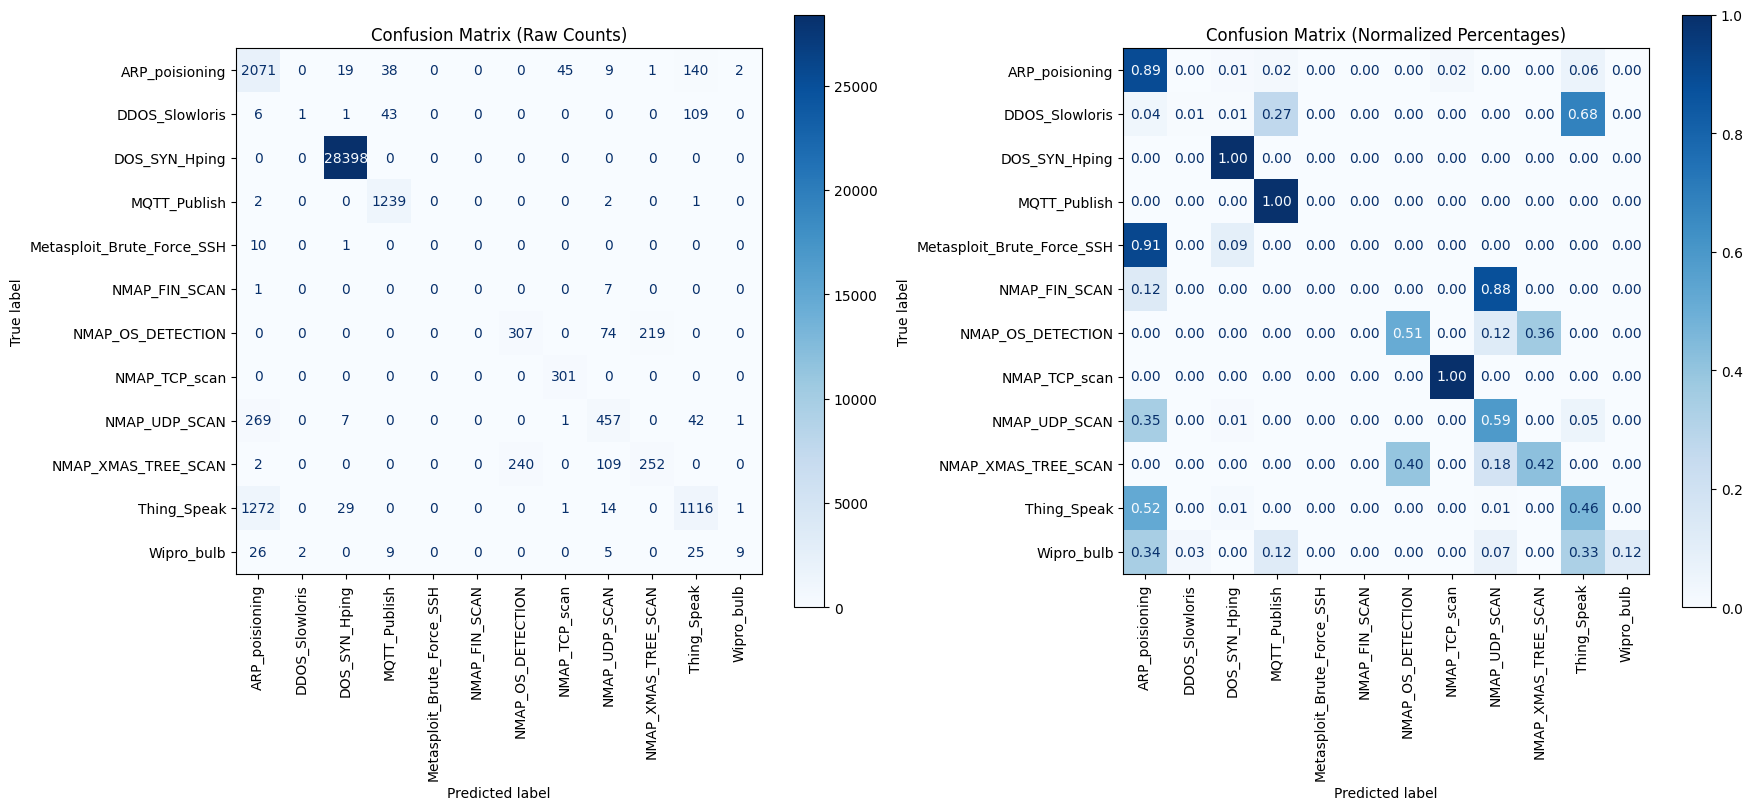

Confusion Matrix for Random Forest:


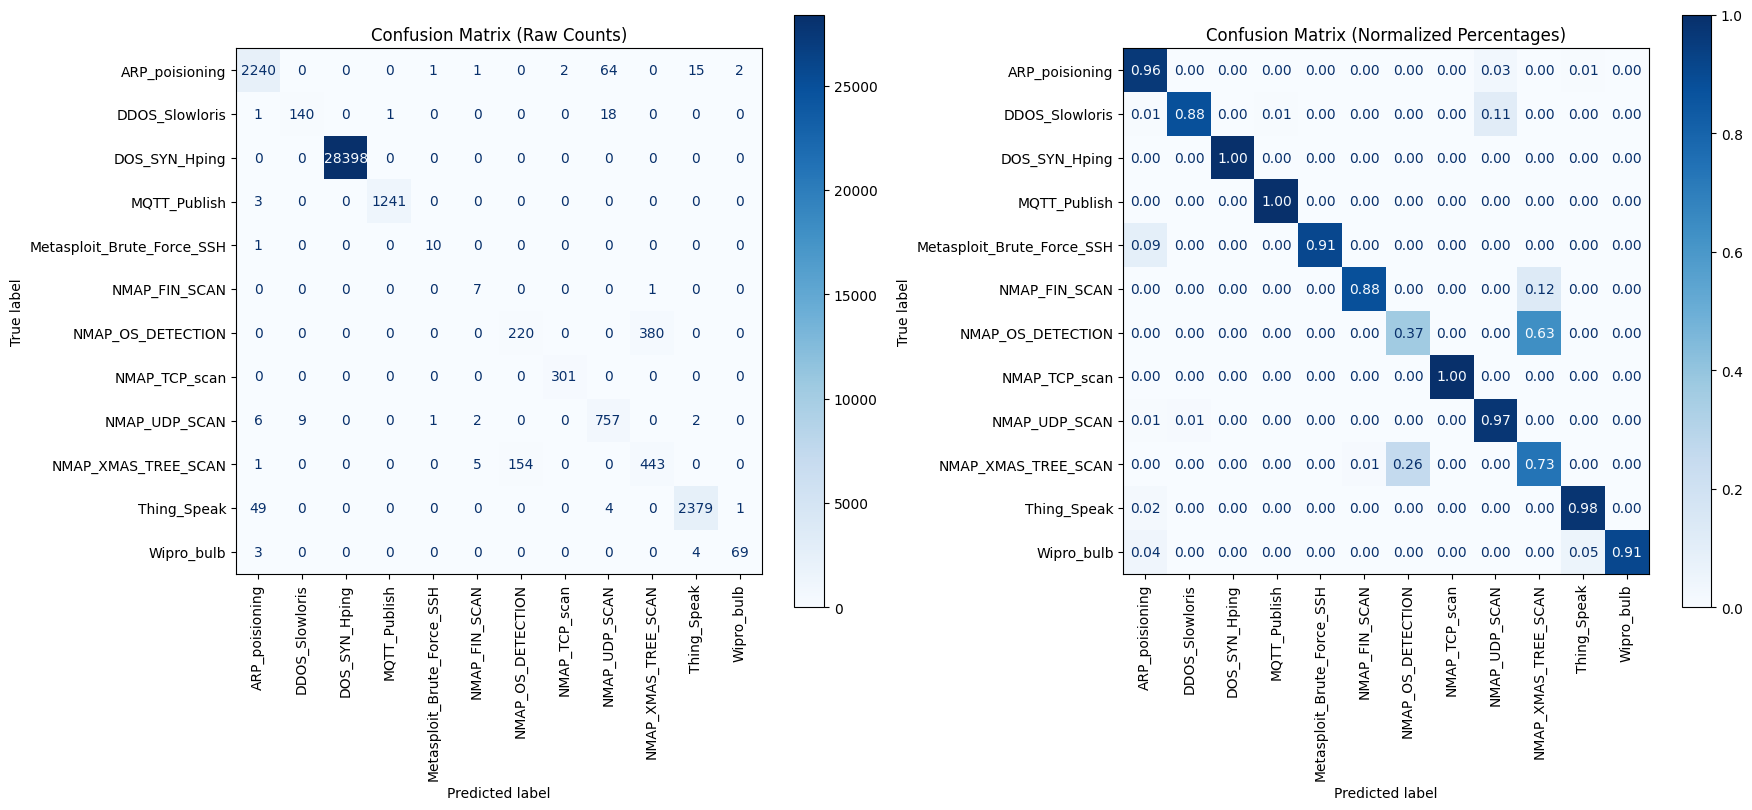

/Users/tejaleburu/anaconda3/envs/default/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Confusion Matrix for Neural Network:


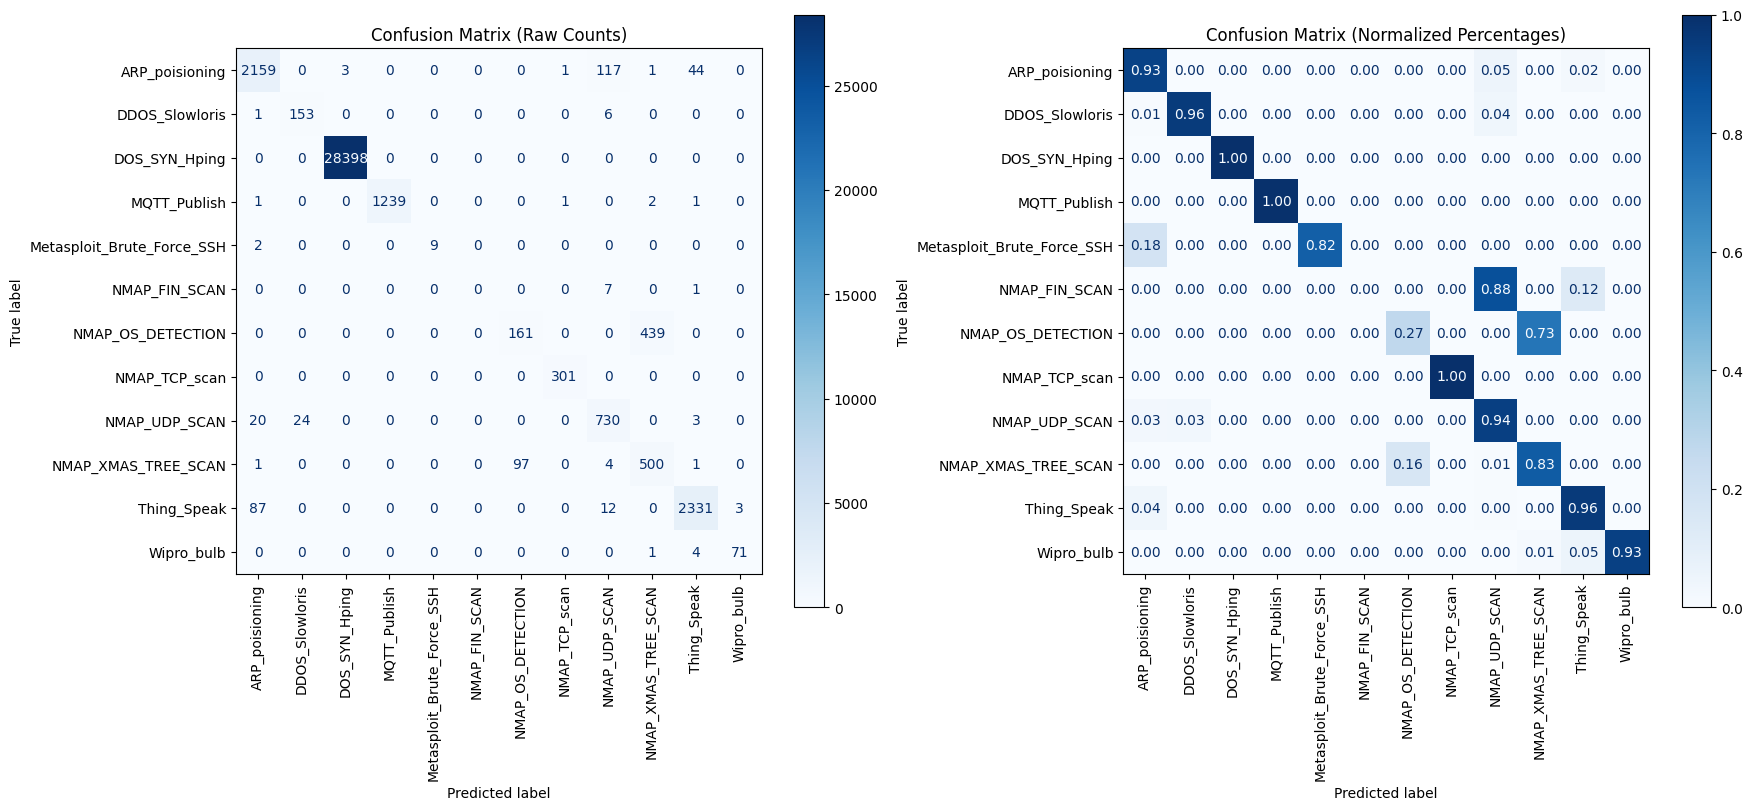

Confusion Matrix for Decision Tree:


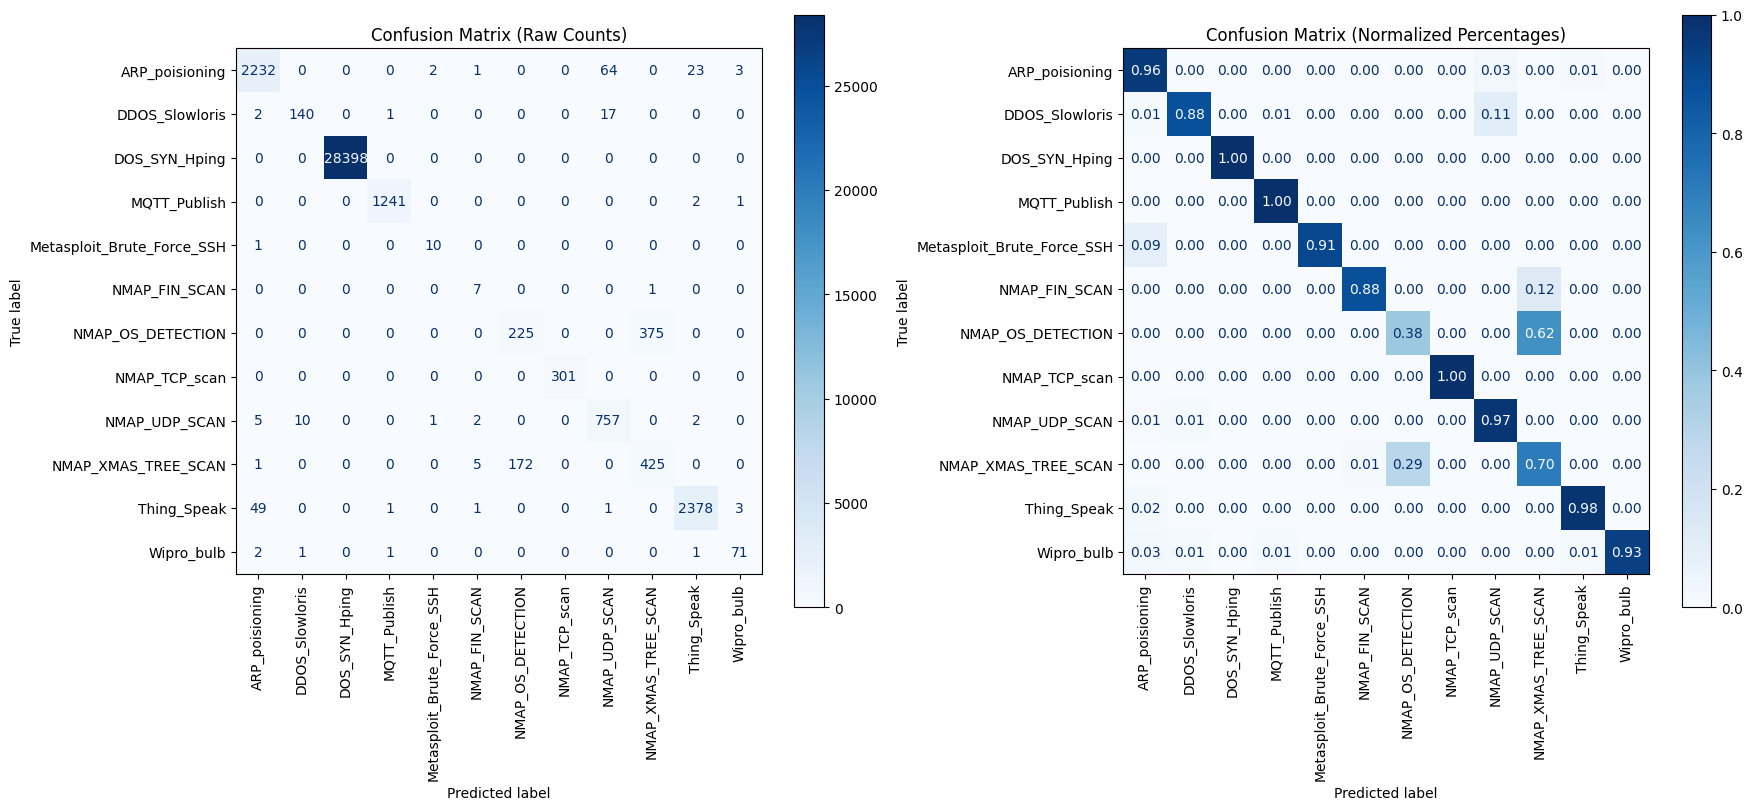

Confusion Matrix for K-Nearest Neighbors:


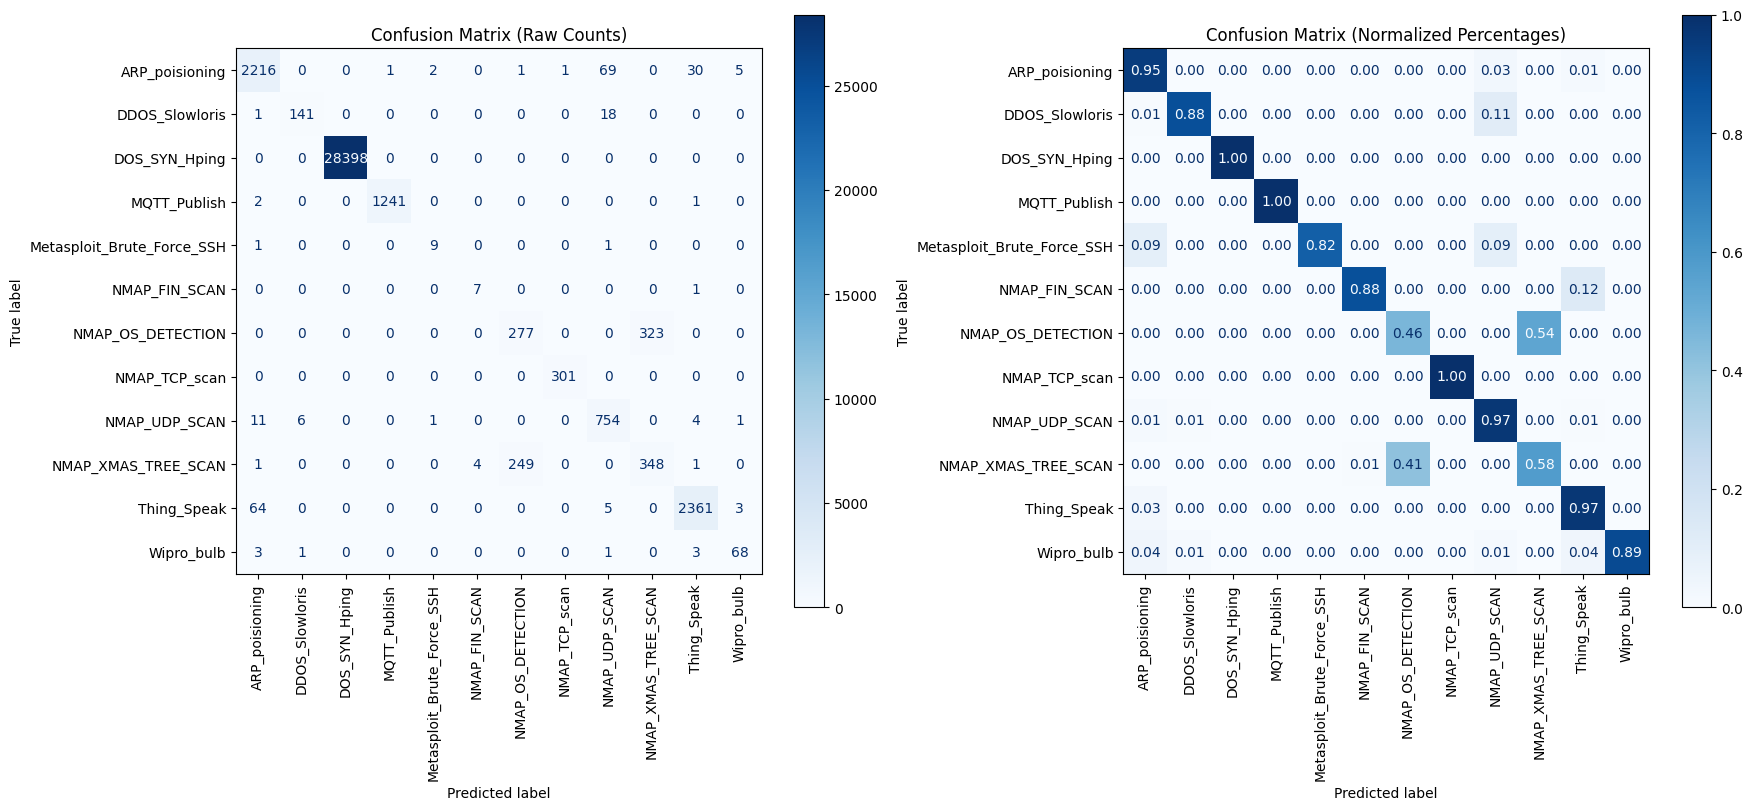

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

# Apply Mutual Information
mi_selector = SelectKBest(mutual_info_classif, k=20)  # Select top 20 features
X_selected = mi_selector.fit_transform(X, y)

# Get selected feature names
selected_features = mi_selector.get_support(indices=True)
selected_feature_names = X.columns[selected_features]
print("Selected Features:", selected_feature_names)

ranked_features = selected_feature_names

accuracy_scores = []
scaler = StandardScaler()

for i in range(1, 20):
    X_subset = X[ranked_features[:i]].copy()

    X_subset_scaled = scaler.fit_transform(X_subset)

    X_train, X_test, y_train, y_test = train_test_split(
        X_subset_scaled, y, test_size=0.3, random_state=42, stratify=y
    )
# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=200, solver='saga', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(100,), max_iter=200, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5)
}

# Train and evaluate models
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    results[name] = accuracy

    y_pred = model.predict(X_test)
    conf_matrix_raw = confusion_matrix(y_test, y_pred)
    conf_matrix_normalized = conf_matrix_raw.astype(np.float64) / conf_matrix_raw.sum(axis=1, keepdims=True)
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    print(f"Confusion Matrix for {name}:")

    # Display raw confusion matrix
    disp_raw = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_raw, display_labels=model.classes_)
    disp_raw.plot(cmap="Blues", ax=axes[0], values_format="d")  # Raw values as integers
    axes[0].set_title("Confusion Matrix (Raw Counts)")
    axes[0].tick_params(axis='x', rotation=90)

    # Display normalized confusion matrix
    disp_normalized = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_normalized, display_labels=model.classes_)
    disp_normalized.plot(cmap="Blues", ax=axes[1], values_format=".2f")  # Percentages formatted to 2 decimal places
    axes[1].set_title("Confusion Matrix (Normalized Percentages)")
    axes[1].tick_params(axis='x', rotation=90)

    # Adjust layout for readability
    plt.tight_layout()
    plt.show()




In [10]:
import pandas as pd

results_df = pd.DataFrame(list(results.items()), columns=["Model", "Validation Accuracy"])
print(results_df)

                 Model  Validation Accuracy
0  Logistic Regression             0.924599
1        Random Forest             0.980209
2       Neural Network             0.976067
3        Decision Tree             0.979668
4  K-Nearest Neighbors             0.977935


## Results Discussion

Based on the following results, we can say that we should chose the random forest model, for the following reasons: 
1. High Validation/Test Accuracy: The Random Forest model achieved 98.02% validation accuracy, which is the highest among all tested models.
2. Confusion Matrix Performance: The normalized confusion matrix indicates strong performance across most classes. 
3. Interpretability vs. Performance: Random Forest models are more interpretable than deep learning models. For example, we could use feature importance analysis to explain the predictions. 

## Improvements Before Deployment

1. Analyze the specific cases where the model misclassified data (e.g., NMAP_OS_DETECTION confusion). It seems like NMAP specifically had the most problems. 
2. We could consider implementing class weighting random forest as documented here: https://statistics.berkeley.edu/sites/default/files/tech-reports/666.pdf
3. We could perhaps do more to include features that are predictive for intra-NMAP attack styles. 

